In [0]:
import torch
import torchtext.vocab as vocab
import torchtext

In [0]:
glove = vocab.GloVe(name='6B', dim=100)

print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


In [0]:
glove.vectors.shape

torch.Size([400000, 100])

In [0]:
glove.itos[20:]

['it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 'between',
 'did',
 'just',
 'national',
 'day',
 'country',
 'under',
 'such',
 'second',
 'then',
 'company',
 'group',
 'any',
 'through',
 'c

In [0]:
glove.stoi['supercalifragilisticexpialidocious']

351309

In [0]:
def get_vector(embeddings, word):
    assert word in embeddings.stoi, f'*{word}* not in the vocabulary specified!'
    return embeddings.vectors[embeddings.stoi[word]]

In [0]:
def closest(embeddings, vector, n = 10):
    """
    Find the closest words for a given vector
    """
    distances = [(neighbour, torch.dist(vector, get_vector(embeddings, neighbour))) for neighbour in embeddings.itos]
    return sorted(distances, key=lambda x: x[1])[:n]

In [0]:
closest(glove, get_vector(glove, 'supercalifragilisticexpialidocious'))

[('supercalifragilisticexpialidocious', tensor(0.)),
 ('liopleurodon', tensor(1.8242)),
 ('guardfish', tensor(1.8615)),
 ('timeslip', tensor(1.8677)),
 ('hypsilophodon', tensor(1.8795)),
 ('bayleaf', tensor(1.8826)),
 ('gryposaurus', tensor(1.8992)),
 ('coelurus', tensor(1.9007)),
 ('thecodontosaurus', tensor(1.9010)),
 ('saurolophus', tensor(1.9011))]

In [0]:
def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

In [0]:
print_tuples(closest(glove, get_vector(glove, 'google')))

(0.0000) google
(3.0772) yahoo
(3.8836) microsoft
(4.1048) web
(4.1082) aol
(4.1165) facebook
(4.3917) ebay
(4.4122) msn
(4.4540) internet
(4.4651) netscape


Finding analogies of the form w1 : w2 :: w3 : ?

In [0]:
def analogy(embeddings, w1, w2, w3, n=5):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))

    closest_words = closest(embeddings, get_vector(embeddings, w2) - get_vector(embeddings, w1) + get_vector(embeddings, w3))

    closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]][:n]
        
    return closest_words

In [0]:
print(analogy(glove, 'obama', 'president', 'elizabeth'))


[obama : president :: elizabeth : ?]
[('catherine', tensor(5.8920)), ('frederick', tensor(6.1170)), ('margaret', tensor(6.1660)), ('edward', tensor(6.2489)), ('william', tensor(6.2714))]


## Data Preprocessing

In [0]:
! pip install spacy

In [0]:
! python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
import spacy
spacy.__version__

'2.2.4'

In [0]:
import torch
from torchtext import data
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
tweets = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False)

tweets = tweets.head(50000)
tweets.head()

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [0]:
tweets = tweets.drop(columns = ['ItemID', 'SentimentSource'], axis = 1)

tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [0]:
tweets.shape

(50000, 2)

In [0]:
tweets['Sentiment'].unique()

array([0, 1])

In [0]:
tweets.Sentiment.value_counts()

1    26921
0    23079
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

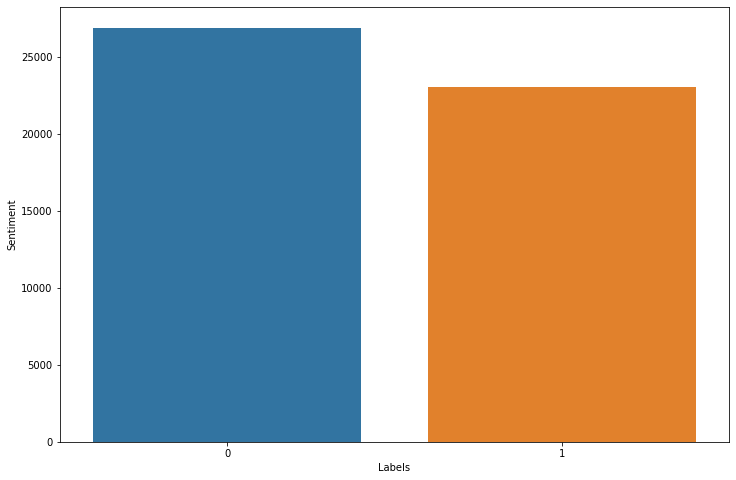

In [0]:
fig = plt.figure(figsize = (12, 8))
ax = sns.barplot(x = tweets.Sentiment.unique(), y = tweets.Sentiment.value_counts())
ax.set(xlabel = 'Labels')

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(tweets, test_size = 0.2, random_state = 42)

In [0]:
train.reset_index(drop = True), test.reset_index(drop = True)

(       Sentiment                                      SentimentText
 0              1  @amyrenea omg so am I lol I fell asleep when i...
 1              0               @Adrienne_Bailon I want a shout out 
 2              0  @Anonymousboy03 Plans for school stuff &amp; a...
 3              0  ... has hit a writer's block .. am loosing my ...
 4              0  ... trying to find people I know! I`m bored, i...
 ...          ...                                                ...
 39995          1   #robotpickuplines are so funny. check them out. 
 39996          1  @annyo84 awh thankss.  yeah, i understand what...
 39997          1  @AmbiguityX ohh you're in twin cities?  i luv ...
 39998          0   Dinara lost again in Roland Garros. Why the S...
 39999          1  *yawn* fucking time zones shit. I'm really sic...
 
 [40000 rows x 2 columns],
       Sentiment                                      SentimentText
 0             1  @aimeesays aww i hope it does fly by because J...
 1     

In [0]:
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)

In [0]:
def tweet_clean(text):
  text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text = re.sub(r'https?:/\/\S+', ' ', text)
  return text.strip()

In [0]:
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
def tokenizer(s):
  return [w.text.lower() for w in nlp(tweet_clean(s))]

In [0]:
TEXT = torchtext.data.Field(tokenize = tokenizer)
LABEL = torchtext.data.LabelField(dtype = torch.float)

In [0]:
datafields = [('Sentiment', LABEL), ('SentimentText', TEXT)]

In [0]:
trn, tst = torchtext.data.TabularDataset.splits(path = '/content/',
                                         train = 'train.csv',
                                         test = 'test.csv',
                                         format = 'csv',
                                         skip_header = True,
                                         fields = datafields)

In [0]:
print(vars(trn.examples[0]))

{'Sentiment': '1', 'SentimentText': ['amyrenea', 'omg', 'so', 'am', 'i', 'lol', 'i', 'fell', 'asleep', 'when', 'it', 'was', 'on', 'last', 'night', 'so', 'now', 'i', 'get', 'to', 'finish', 'it']}


In [0]:
TEXT.build_vocab(trn, max_size = 25000, vectors = 'glove.6B.100d', unk_init = torch.Tensor.normal_)
LABEL.build_vocab(trn)

In [0]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f899abc82f0>, {'1': 0, '0': 1})


In [0]:
batch_size = 64
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
    (trn, tst),
    batch_size = batch_size,
    sort_key = lambda x : len(x.SentimentText),
    sort_within_batch = False
)

# Model

In [0]:
import torch.nn as nn

In [0]:
class RNN(nn.Module):
  def __init__(self, vocab_size, embed, inp, hid, out, n_layers, bidirectional=True, dropout=dropout):
    super().__init__()
    self.embedding = nn.Embedding(embed, vocab_size)
    self.rnn = nn.GRU(embed, hid, num_layers = n_layers,
                        bidirectional = bidirectional, dropout = dropout)
    self.fc = nn.Linear(hid*2, out)
    self.dropout = nn.Dropout(dropout)
  def forward(self, text):
    embedded = self.dropout(self.embedding(text))
    output, hidden = self.rnn(embedded)
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
    return self.fc(hidden.squeeze(0))

In [0]:
inp = len(TEXT.vocab)
embed = 100
hid = 20
out = 1
n_layers = 2
bidirectional = True
dropout = True

In [0]:
model = RNN(inp, bidirectional, embed=100, hid=20, out=1, n_layers=2, dropout=0.5)

In [0]:
model

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(25002, 1, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)